In [ ]:
#importing necessary modules
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from collections import Counter



In [90]:
train = pd.read_csv('train_set_cat.csv')

In [120]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 95617 entries, 0 to 95807
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Current Loan Amount        95617 non-null  int64  
 1   Credit Score               95617 non-null  float64
 2   Annual Income              95617 non-null  float64
 3   Monthly Debt               95617 non-null  float64
 4   Years of Credit History    95617 non-null  float64
 5   Number of Open Accounts    95617 non-null  int64  
 6   Number of Credit Problems  95617 non-null  int64  
 7   Current Credit Balance     95617 non-null  int64  
 8   Maximum Open Credit        95617 non-null  float64
 9   Bankruptcies               95617 non-null  float64
 10  Tax Liens                  95617 non-null  float64
 11  TARGET                     95617 non-null  int64  
 12  credit_score_missing       95617 non-null  int64  
 13  Term_of_loan               95617 non-null  int64  


In [91]:
train.drop(labels=['Loan ID', 'Customer ID'], axis=1, inplace=True)

# These two features are only for identification.

In [92]:
# # Missing Values

# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [93]:
missing_values_table(train)

# A curious thing about the table below is the last 10 features have the same number o missing values.
# I will go deeper and figure out what is happening.

Your selected dataframe has 15 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
Months since last delinquent,50904,53.1
Annual Income,18394,19.2
Credit Score,18394,19.2
Years in current job,4049,4.2
Bankruptcies,190,0.2
Tax Liens,8,0.0
Maximum Open Credit,1,0.0


In [94]:
# Drop the columns with > 50% missing
train.drop(columns = 'Months since last delinquent', axis=1, inplace=True)

In [95]:
# As the number of missing values is so low in the 'Maximum Open Credit' I will drop them.

for i in train['Maximum Open Credit'][train['Maximum Open Credit'].isnull() == True].index:
    train.drop(labels=i, inplace=True)
missing_values_table(train)

Your selected dataframe has 14 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,18394,19.2
Annual Income,18394,19.2
Years in current job,4049,4.2
Bankruptcies,190,0.2
Tax Liens,8,0.0


In [96]:
# As the number of missing values is so low in the 'Tax Liens' I will drop them.

for i in train['Tax Liens'][train['Tax Liens'].isnull() == True].index:
    train.drop(labels=i, inplace=True)
missing_values_table(train)

Your selected dataframe has 14 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,18391,19.2
Annual Income,18391,19.2
Years in current job,4049,4.2
Bankruptcies,182,0.2


In [97]:
# As the number of missing values is so low in the 'Bankruptcies' I will drop them.

for i in train['Bankruptcies'][train['Bankruptcies'].isnull() == True].index:
    train.drop(labels=i, inplace=True)
missing_values_table(train)

Your selected dataframe has 14 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,18354,19.2
Annual Income,18354,19.2
Years in current job,4049,4.2


* converting LOAN_STATUS to binary values an renaming it as TARGET

In [98]:
# Map values in 'loan_status' column /target column to numerical
train['TARGET'] = train['Loan Status'].map({
    'Fully Paid': 0, #non- Defaulter
    'Charged Off': 1 # defaulter
})


In [99]:
train = train.drop('Loan Status', axis=1)

some values are missing in credit column .I believe tha these are not missing completely at random.Therefore , I'll make a separate column credit score missing.

In [100]:
train['credit_score_missing'] = train['Credit Score'].isna().astype(int)


In [101]:
# Check average target value when credit score is missing vs not missing
print(train.groupby('credit_score_missing')['TARGET'].mean())


credit_score_missing
0    0.216326
1    0.286749
Name: TARGET, dtype: float64


Most Credit score range form 300 to 850. To impute misisng values i'll use 600 which is neither too low nor too high

In [102]:
train['Credit Score'] = train['Credit Score'].fillna(600)  # A conservative, lower-end score


There are values in credit column which are really high.Like in real life credit score exist between 300-850 . So all values above 800 are clipped to 800.
and below 600 are clipped to 300

In [103]:
train['Credit Score'] = train['Credit Score'].clip(lower=300, upper=850)

<Axes: xlabel='count', ylabel='Years in current job'>

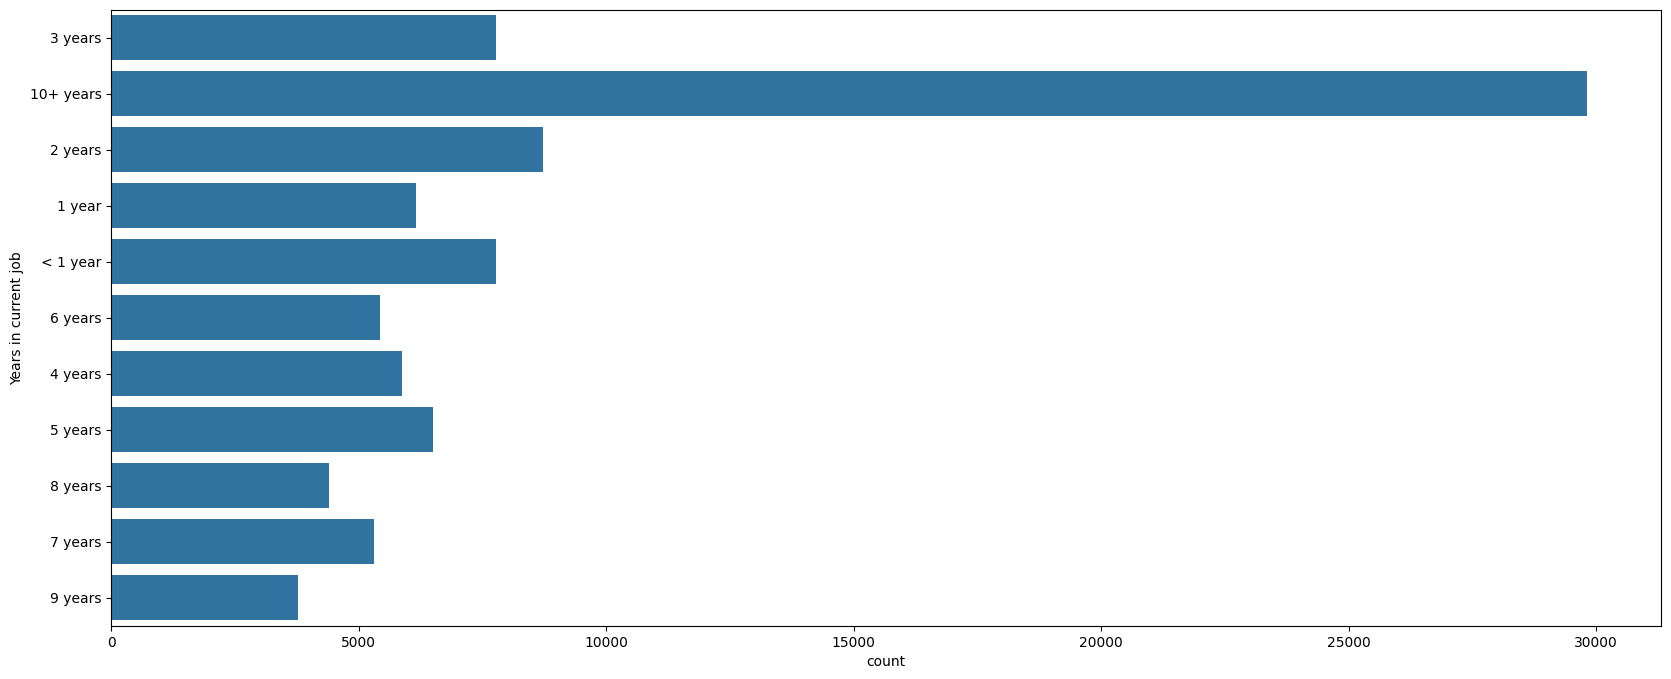

In [104]:
# I will figure out what value is more present in this feature.

plt.figure(figsize=(20,8))

sns.countplot(train['Years in current job'])

# We can see that the value '10+ years' is strongly present in this feature, so I will use this value to fill the
# missing values.

In [105]:
# Calculate the mode of the column
mode_value = train['Years in current job'].mode()[0]

# Fill missing values with the mode
train['Years in current job'].fillna(mode_value, inplace=True)


C:\Users\easntop\AppData\Local\Temp\ipykernel_15176\3358840444.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Years in current job'].fillna(mode_value, inplace=True)


In [106]:
# Calculate the median of Annual Income
median_income = train['Annual Income'].median()

# Fill missing values with the median
train['Annual Income'].fillna(median_income, inplace=True)


C:\Users\easntop\AppData\Local\Temp\ipykernel_15176\855467589.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Annual Income'].fillna(median_income, inplace=True)


In [107]:
missing_values_table(train)

Your selected dataframe has 15 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [108]:
import pandas as pd

# Assume your DataFrame is called 'df'
categorical_columns = train.select_dtypes(include=['object', 'category']).columns
num_categorical = len(categorical_columns)

print(f"Number of categorical features: {num_categorical}")
print("Categorical columns:")
print(categorical_columns.tolist())


Number of categorical features: 2
Categorical columns:
['Term', 'Years in current job']


In [109]:
# Select only numerical columns
numerical_df = train.select_dtypes(include=['int64','float64'])

# Compute correlation with the target
correlation_with_target = numerical_df.corr(method='pearson')['TARGET'].sort_values(ascending=False)

print("Pearson correlation with TARGET:")
print(correlation_with_target)


Pearson correlation with TARGET:
TARGET                       1.000000
Credit Score                 0.102564
credit_score_missing         0.065922
Number of Open Accounts      0.012233
Tax Liens                    0.010984
Monthly Debt                 0.006970
Number of Credit Problems    0.002393
Bankruptcies                -0.006917
Maximum Open Credit         -0.008540
Current Credit Balance      -0.011977
Years of Credit History     -0.024055
Annual Income               -0.052015
Current Loan Amount         -0.196171
Name: TARGET, dtype: float64


In [110]:
#Font for graph labels, this is used for all graphs in this notebook
label_font = {"fontsize": 12,
              "color" : "darkred",
             'weight': 'normal'}
#Font for graph title, this is used for all graphs in this notebook
title_font = {"fontsize": 15,
              "color" : "darkred",
             'weight': 'normal'}

##### Heatmap

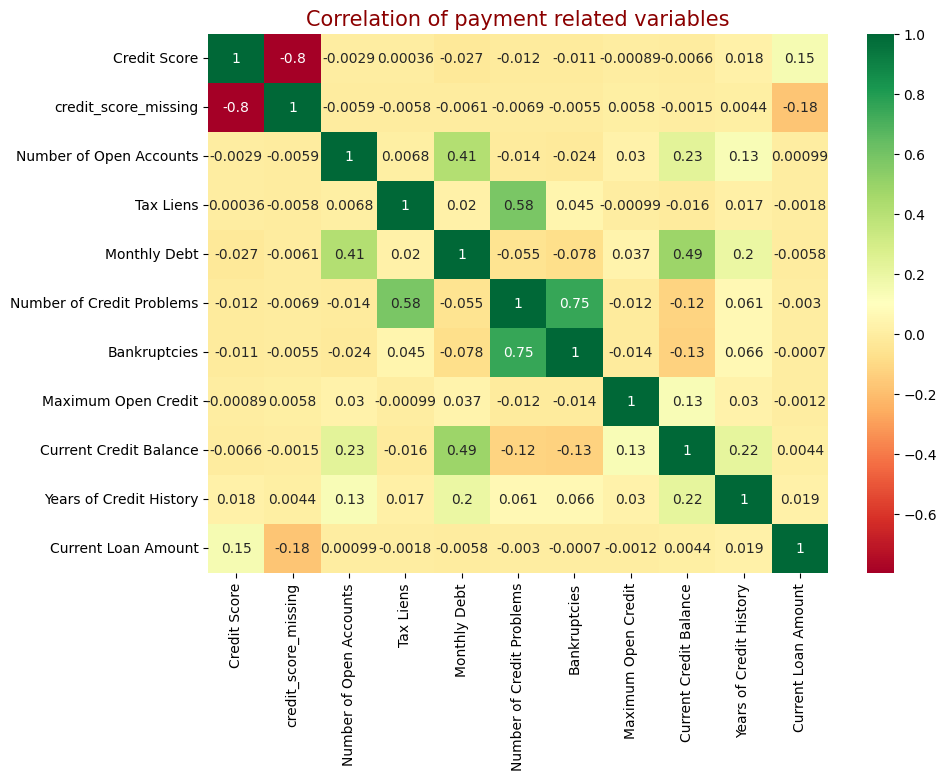

In [111]:
# Mapping the group of payment related variables
tg_amt = train[['Credit Score',
'credit_score_missing',
'Number of Open Accounts',
'Tax Liens',
'Monthly Debt',
'Number of Credit Problems',
'Bankruptcies',
'Maximum Open Credit',
'Current Credit Balance',
'Years of Credit History',
'Current Loan Amount'
       ]].corr()

plt.figure(figsize = (10, 7))
sns.heatmap(tg_amt, annot=True, cmap="RdYlGn")
plt.title('Correlation of payment related variables', title_font)
plt.show()

C:\Users\easntop\AppData\Local\Temp\ipykernel_15176\4058029321.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Term', y='TARGET', data=train, estimator='mean', ci=None, palette='Set2')
C:\Users\easntop\AppData\Local\Temp\ipykernel_15176\4058029321.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Term', y='TARGET', data=train, estimator='mean', ci=None, palette='Set2')


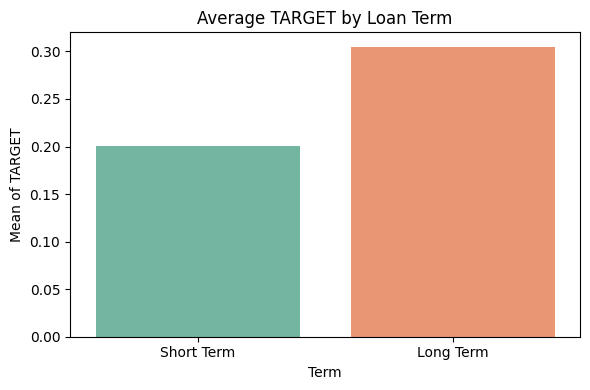

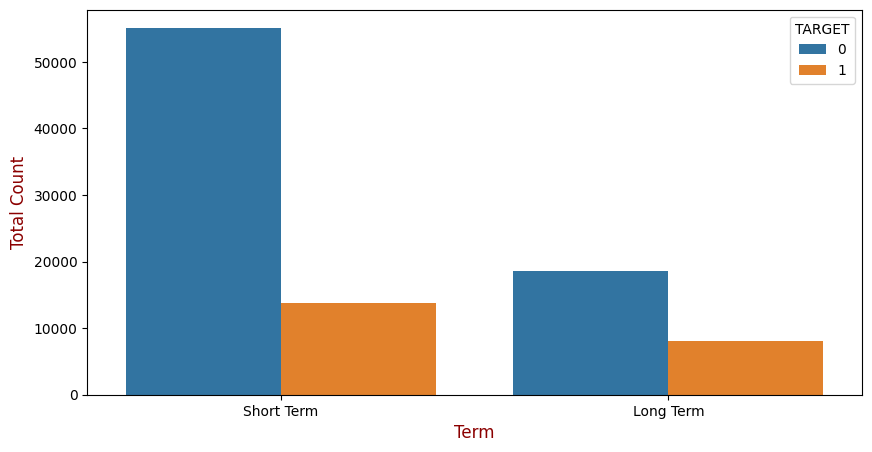

C:\Users\easntop\AppData\Local\Temp\ipykernel_15176\4058029321.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Term', y='TARGET', data=train, palette='Set3')


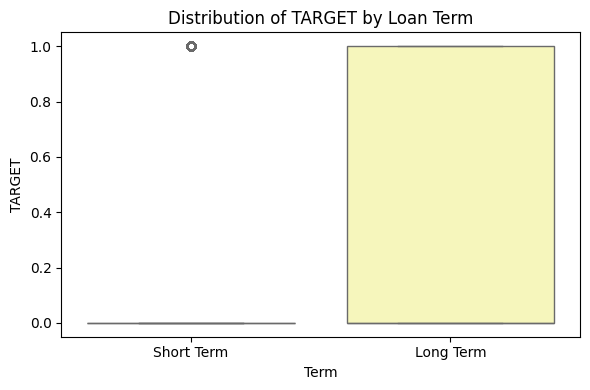

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(x='Term', y='TARGET', data=train, estimator='mean', ci=None, palette='Set2')
plt.title('Average TARGET by Loan Term')
plt.ylabel('Mean of TARGET')
plt.xlabel('Term')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x = "Term", hue = 'TARGET', data = train)
plt.xlabel("Term", label_font) #Set x axis label
plt.ylabel("Total Count", label_font) #Set y axis label
plt.show()


plt.figure(figsize=(6, 4))
sns.boxplot(x='Term', y='TARGET', data=train, palette='Set3')
plt.title('Distribution of TARGET by Loan Term')
plt.ylabel('TARGET')
plt.xlabel('Term')
plt.tight_layout()
plt.show()



Clip (limit) the data in the column between these two values:
* Any values below q1 are set to q1, and
* Any values above q99 are set to q99.   

In [113]:
for col in ['Credit Score', 'Annual Income']:
    q1 = np.percentile(train[col], 1)
    q99 = np.percentile(train[col], 99)
    train[col] = np.clip(train[col], q1, q99) 


Hence, Converting categorical column to Ordinal encoding so that it could be used by the algorithm

In [ ]:

# --------------------
# Encode 'Term' column
# --------------------
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}

train['Term_of_loan'] = train['Term'].map(term_mapping)

# -------------------------------
# Encode 'Years in current job'
# -------------------------------
def clean_years(value):
    # Handle "<1 year" as 0
    if '<1' in str(value):
        return 0
    # Handle "10+ years" as 10
    elif '10+' in str(value):
        return 11
    else:
        # Extract digits using regex (safe for cases like '2 years', '5 yrs')
        num = re.findall(r'\d+', str(value))
        return int(num[0]) if num else None  # None if no number found

train['Years_in_current__job'] = train['Years in current job'].apply(clean_years)

# --------------------
#  Drop original columns  not needed
# --------------------
train.drop(['Term', 'Years in current job'], axis=1, inplace=True)

# --------------------
# Check the result
# --------------------
print(train[['Term_of_loan', 'Years_in_current__job']].head())


   Term_of_loan  Years_in_current__job
0             0                      3
1             0                     11
2             0                      2
3             0                     11
4             1                     11


Import to excel

In [117]:
# Export to Excel
train.to_excel('train_prepared.xlsx', index=False)

print("notsampled training data saved as 'train_ordinal.xlsx'.")


notsampled training data saved as 'train_ordinal.xlsx'.
